In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import glob

# Enrolment
enrol_df = pd.concat(
    [pd.read_csv(f) for f in glob.glob("../data/api_data_aadhar_enrolment/*.csv")],
    ignore_index=True
)
enrol_df["total_enrolment"] = (
    enrol_df["age_0_5"] + enrol_df["age_5_17"] + enrol_df["age_18_greater"]
)

state_enrol = enrol_df.groupby("state")["total_enrolment"].sum().reset_index()

# Demographic updates
demo_df = pd.concat(
    [pd.read_csv(f) for f in glob.glob("../data/api_data_aadhar_demographic/*.csv")],
    ignore_index=True
)
demo_age_cols = [c for c in demo_df.columns if c.startswith("demo_age")]
demo_df["total_demo_updates"] = demo_df[demo_age_cols].sum(axis=1)
state_demo = demo_df.groupby("state")["total_demo_updates"].sum().reset_index()

# Biometric updates
bio_df = pd.concat(
    [pd.read_csv(f) for f in glob.glob("../data/api_data_aadhar_biometric/*.csv")],
    ignore_index=True
)
bio_age_cols = [c for c in bio_df.columns if c.startswith("bio_age")]
bio_df["total_bio_updates"] = bio_df[bio_age_cols].sum(axis=1)
state_bio = bio_df.groupby("state")["total_bio_updates"].sum().reset_index()

# Merge
df = (
    state_enrol
    .merge(state_demo, on="state", how="left")
    .merge(state_bio, on="state", how="left")
)

df.fillna(0, inplace=True)
df["total_updates"] = df["total_demo_updates"] + df["total_bio_updates"]

df.head()


,state,total_enrolment,total_demo_updates,total_bio_updates,total_updates
0,100000,218,2.0,0.0,2.0
1,Andaman & Nicobar Islands,114,1059.0,2384.0,3443.0
2,Andaman and Nicobar Islands,397,6187.0,18314.0,24501.0
3,Andhra Pradesh,127681,2295505.0,3714592.0,6010097.0
4,Arunachal Pradesh,4344,36443.0,72394.0,108837.0


In [3]:
national_expected_ratio = df["total_updates"].sum() / df["total_enrolment"].sum()

national_expected_ratio


np.float64(21.903003328732886)

In [4]:
df["expected_updates"] = df["total_enrolment"] * national_expected_ratio
df[["state", "total_updates", "expected_updates"]].head()


,state,total_updates,expected_updates
0,100000,2.0,4.774855e+03
1,Andaman & Nicobar Islands,3443.0,2.496942e+03
2,Andaman and Nicobar Islands,24501.0,8.695492e+03
3,Andhra Pradesh,6010097.0,2.796597e+06
4,Arunachal Pradesh,108837.0,9.514665e+04


In [5]:
df["ARGI"] = df["total_updates"] / df["expected_updates"]

df.sort_values("ARGI", ascending=False).head(10)


,state,total_enrolment,total_demo_updates,total_bio_updates,total_updates,expected_updates,ARGI
12,Daman & Diu,21,644.0,2185.0,2829.0,4.599631e+02,6.150494
33,ODISHA,1,50.0,34.0,84.0,2.190300e+01,3.835091
13,Daman and Diu,120,1552.0,6763.0,8315.0,2.628360e+03,3.163569
48,WESTBENGAL,1,57.0,12.0,69.0,2.190300e+01,3.150253
2,Andaman and Nicobar Islands,397,6187.0,18314.0,24501.0,8.695492e+03,2.817667
7,Chandigarh,2723,83361.0,74482.0,157843.0,5.964188e+04,2.646513
3,Andhra Pradesh,127681,2295505.0,3714592.0,6010097.0,2.796597e+06,2.149075
8,Chhattisgarh,103219,2005434.0,2648729.0,4654163.0,2.260806e+06,2.058630
10,Dadra and Nagar Haveli,744,6033.0,27235.0,33268.0,1.629583e+04,2.041503
15,Goa,2333,35120.0,68397.0,103517.0,5.109971e+04,2.025785


In [6]:
def classify_argi(x):
    if x > 1.2:
        return "Over-stressed"
    elif x < 0.8:
        return "Under-utilized"
    else:
        return "Normal"

df["ARGI_status"] = df["ARGI"].apply(classify_argi)

df["ARGI_status"].value_counts()


ARGI_status
Over-stressed     29
Normal            15
Under-utilized    11
Name: count, dtype: int64

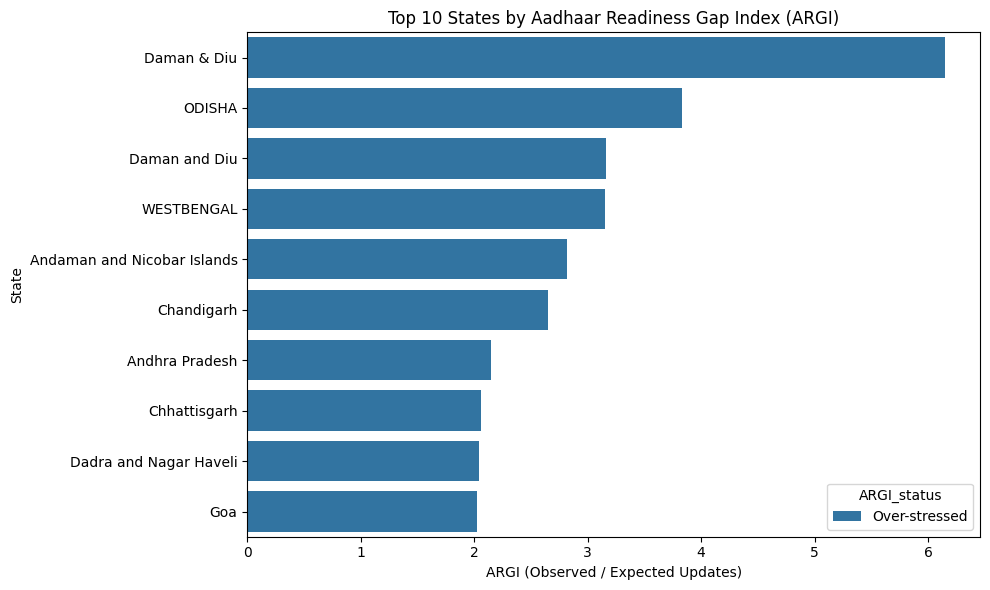

In [7]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df.sort_values("ARGI", ascending=False).head(10),
    x="ARGI",
    y="state",
    hue="ARGI_status",
    dodge=False
)

plt.title("Top 10 States by Aadhaar Readiness Gap Index (ARGI)")
plt.xlabel("ARGI (Observed / Expected Updates)")
plt.ylabel("State")
plt.tight_layout()
plt.show()
